<a href="https://colab.research.google.com/github/DEB-PROSAD-SEN/Kaggle_competition/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install catboost


In [21]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, make_scorer



In [22]:
# Load train and test datasets
train = pd.read_csv(r"/content/train (1).csv")
test = pd.read_csv(r"/content/test (1).csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
train.isnull().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1199 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallCond  

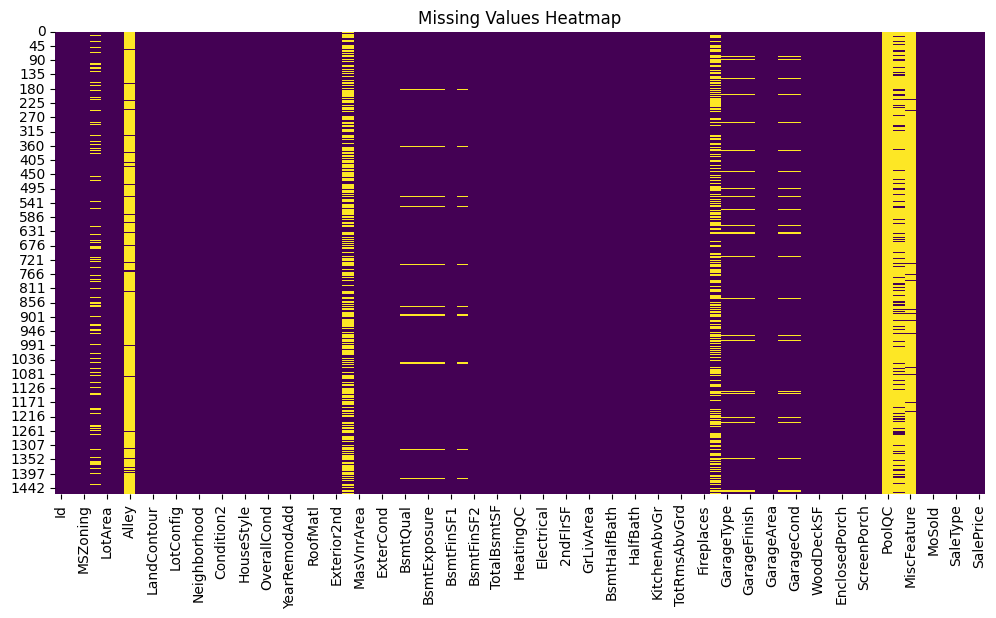

In [24]:
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [27]:
missing = train.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False).head(20)

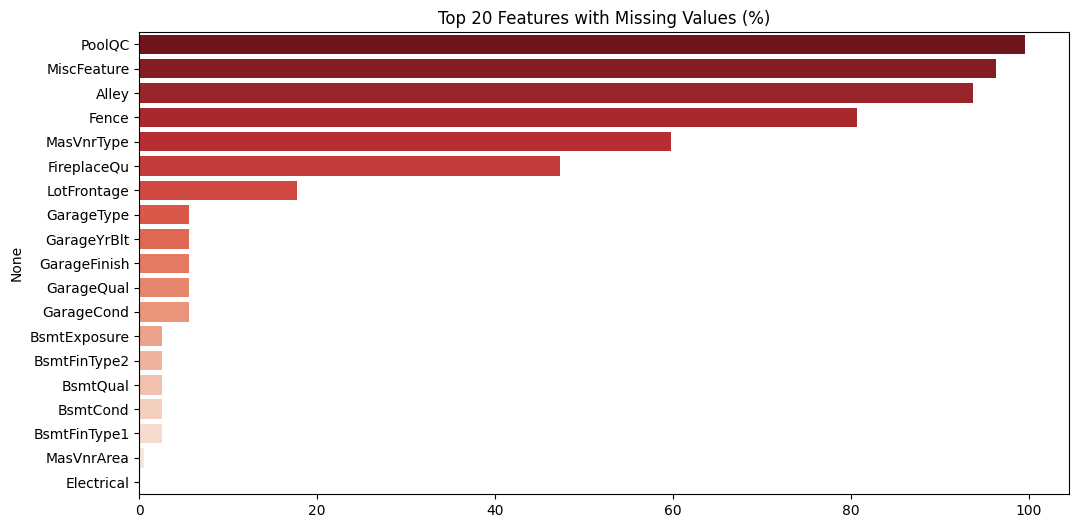

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing.values, y=missing.index, palette="Reds_r")
plt.title("Top 20 Features with Missing Values (%)")
plt.show()

In [29]:
corr = train.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

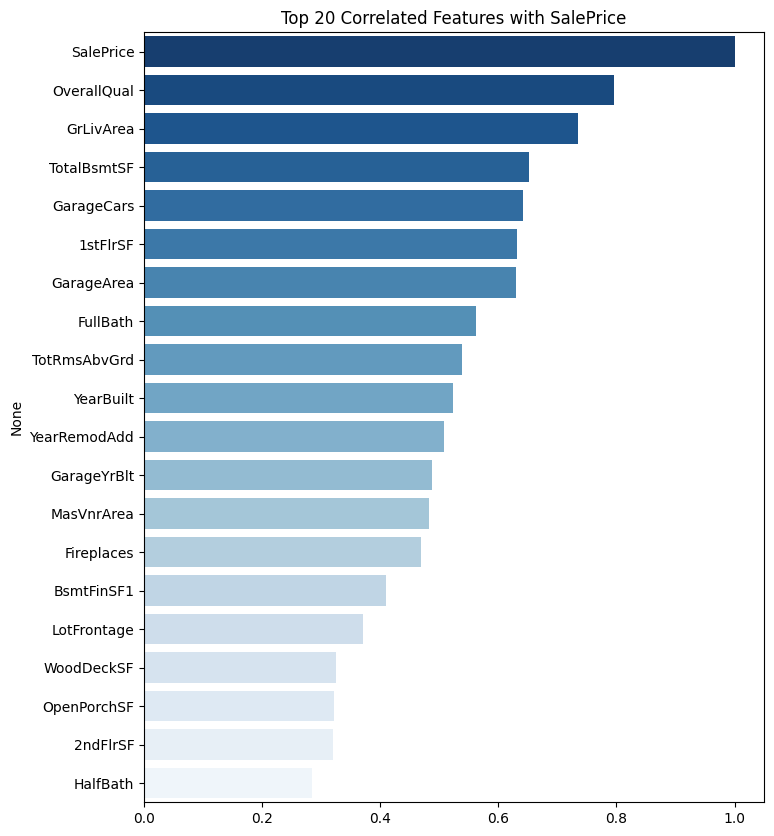

In [30]:
plt.figure(figsize=(8, 10))
sns.barplot(x=corr.values[:20], y=corr.index[:20], palette="Blues_r")
plt.title("Top 20 Correlated Features with SalePrice")
plt.show()

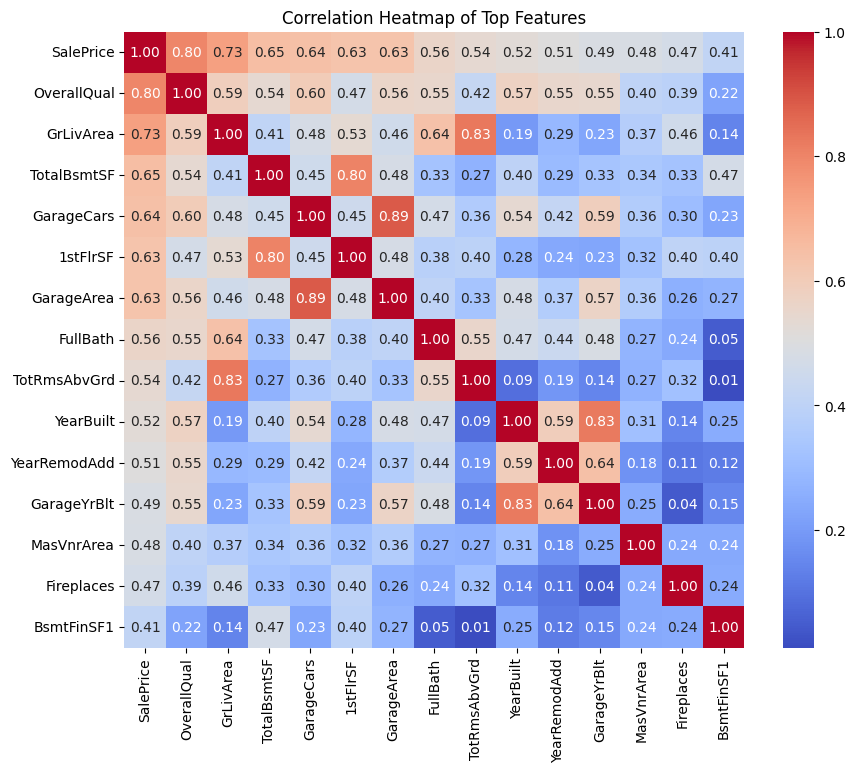

In [31]:
top_corr_features = corr.index[:15]
plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features")
plt.show()

In [32]:
X_tmp = train.drop(columns=["SalePrice", "Id"])
y_tmp = train["SalePrice"]

In [33]:
X_tmp = X_tmp.fillna(0)
X_tmp = pd.get_dummies(X_tmp, drop_first=True)

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_tmp, y_tmp)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [35]:
importances = pd.Series(rf.feature_importances_, index=X_tmp.columns)
top_features = importances.sort_values(ascending=False).head(20)

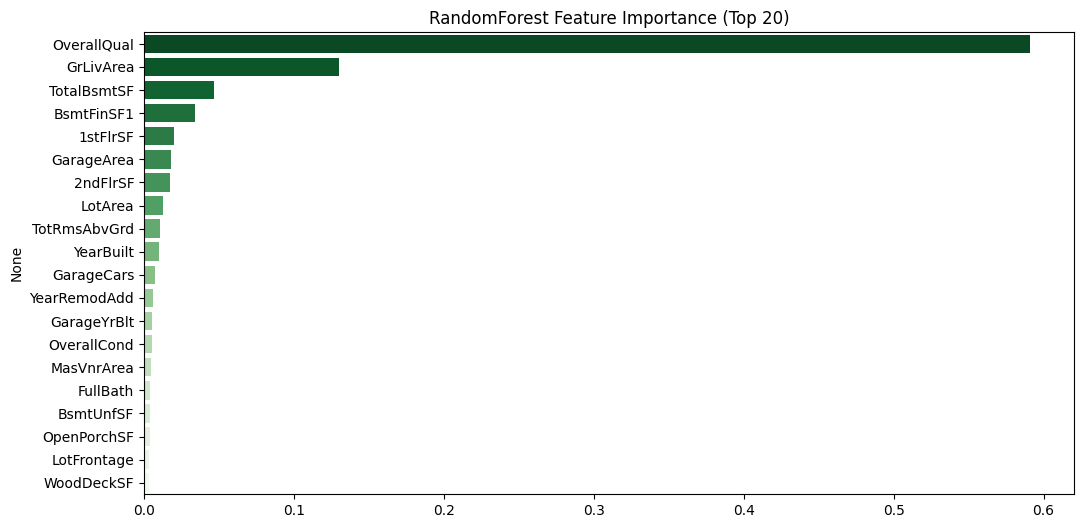

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="Greens_r")
plt.title("RandomForest Feature Importance (Top 20)")
plt.show()

In [23]:
# Remove very large houses with abnormally low price
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)
print("After removing outliers:", train.shape)


After removing outliers: (1458, 81)


In [4]:
def feature_engineering(df):
    df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"].fillna(0) + 0.5 * df["BsmtHalfBath"].fillna(0)
    df["TotalSF"] = df["TotalBsmtSF"].fillna(0) + df["1stFlrSF"] + df["2ndFlrSF"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["IsRemodeled"] = (df["YearRemodAdd"] != df["YearBuilt"]).astype(int)
    df["IsNew"] = (df["YrSold"] == df["YearBuilt"]).astype(int)
    if "OverallCond" in df.columns:
        df["QualCond"] = df["OverallQual"] * df["OverallCond"]
    return df

train = feature_engineering(train)
test = feature_engineering(test)


In [5]:
y = np.log1p(train["SalePrice"])
X = train.drop(columns=["SalePrice", "Id"])
test_id = test["Id"]
X_test = test.drop(columns=["Id"])


In [6]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
skewness = X[num_cols].apply(lambda x: x.dropna().skew()).sort_values(ascending=False)
skewed_feats = skewness[abs(skewness) > 0.75].index

X[skewed_feats] = np.log1p(X[skewed_feats] + 1)
X_test[skewed_feats] = np.log1p(X_test[skewed_feats] + 1)


In [7]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

# Rare category encoding
def rare_encoder(df, col, threshold=0.01):
    freq = df[col].value_counts(normalize=True)
    rare = freq[freq < threshold].index
    df[col] = df[col].replace(rare, "Rare")
    return df

for col in cat_features:
    full_data = pd.concat([X[col], X_test[col]], axis=0)
    full_data = rare_encoder(full_data.to_frame(), col)
    X[col], X_test[col] = full_data.iloc[:len(X)], full_data.iloc[len(X):]

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
feature_selector = SelectKBest(score_func=mutual_info_regression, k=120)


In [14]:
models = {
    "Ridge": Ridge(alpha=10),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

# XGBoost (GPU)
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        tree_method="gpu_hist", predictor="gpu_predictor"
    )
except:
    pass

# LightGBM (GPU)
try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, random_state=42, device="gpu"
    )
except:
    pass

# CatBoost (GPU)
try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=6,
        random_state=42, verbose=0, task_type="GPU"
    )
except:
    pass


In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def log_rmse_cv(model, X, y):
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("selector", feature_selector),
        ("model", model)
    ])
    scorer = make_scorer(lambda y_true, y_pred: rmse(y_true, y_pred), greater_is_better=False)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring=scorer, n_jobs=-1)
    return -scores.mean()


In [16]:
cv_results = {}
for name, model in models.items():
    score = log_rmse_cv(model, X, y)
    cv_results[name] = score
    print(f"{name}: CV Log-RMSE = {score:.5f}")

best_model_name = min(cv_results, key=cv_results.get)
print(f"\nBest Model: {best_model_name} with CV Log-RMSE = {cv_results[best_model_name]:.5f}")


Ridge: CV Log-RMSE = 0.11706
RandomForest: CV Log-RMSE = 0.13355
XGBoost: CV Log-RMSE = 0.11953
LightGBM: CV Log-RMSE = 0.12536
CatBoost: CV Log-RMSE = 0.12054

Best Model: Ridge with CV Log-RMSE = 0.11706


In [17]:
from sklearn.pipeline import Pipeline

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("selector", feature_selector),
    ("model", models[best_model_name])
])

final_pipeline.fit(X, y)
preds = np.expm1(final_pipeline.predict(X_test))

submission = pd.DataFrame({"Id": test_id, "SalePrice": preds})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv is saved!")


✅ submission.csv is saved!
